# Analyzing CIA Factbook Data Using SQL

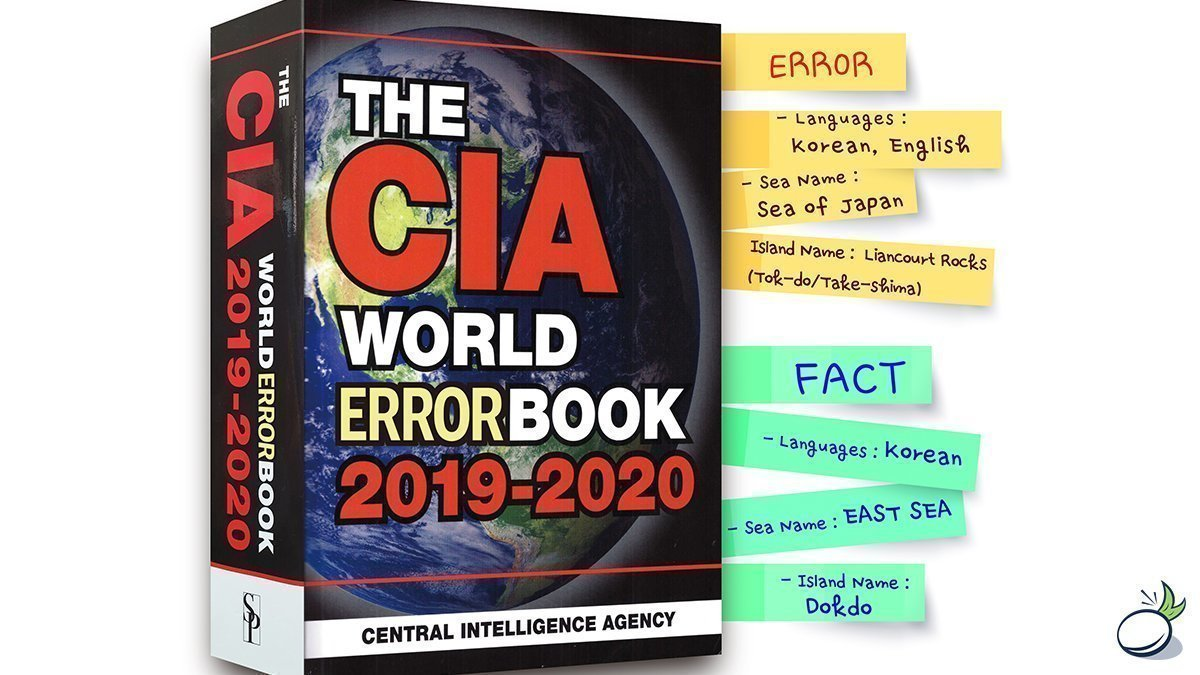

The goal of our work - analyze data with SQL query from <a href="https://www.cia.gov/the-world-factbook/" target="_blank">CIA World Factbook</a>. In our work we use dataset from  <a href="https://www.kaggle.com/samaxtech/cia-factbook-data?select=factbook.db" target="_blank">Kaggle</a>  in the format sqllite database file.
After downloading database for local HDD connect to it. 

In [1]:
%%capture
%load_ext sql
%sql sqlite:///data/factbook.db

View general information about database using this query

In [2]:
%%sql
SELECT 
    *
FROM 
    sqlite_master
WHERE type='table';

 * sqlite:///data/factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


As we see  from output of SQL query the database "factbook.dd" contains two tables:
* 1. sqlite_sequence - service table 
* 2. facts	- table with data
also in the column "sql" we see SQL script for creating tables and we can see name and type of data of columns of the table "facts" 

View first five rows and all columns with this query.

In [3]:
%%sql
SELECT 
    *
FROM 
    facts
LIMIT 5;

 * sqlite:///data/factbook.db
Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


In [4]:
%%sql
SELECT 
    *
FROM 
    sqlite_master
WHERE type='table';

 * sqlite:///data/factbook.db
Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


## Determination MAX,  MIN and AVG values for population, population growth, area and water  for countries and define outliers.

Extract MIN and Max for total population of countries.

In [5]:
%%sql
SELECT 
    name, population AS "Max & Min population" 
FROM 
    facts
WHERE 
   population = (SELECT MAX(population) FROM facts)  
   OR 
   population = (SELECT MIN(population) FROM facts)
ORDER BY "Max & Min population" DESC ;

 * sqlite:///data/factbook.db
Done.


name,Max & Min population
World,7256490011
Antarctica,0


Extract MAX and MIN values for population growth

In [6]:
%%sql
SELECT 
   name, population_growth as "Max & Min populatin growth %"
FROM 
    facts
WHERE 
   population_growth = (SELECT MAX (population_growth) FROM facts)
   OR 
   population_growth = (SELECT MIN (population_growth) FROM facts)
ORDER BY "Max & Min populatin growth %" DESC;

 * sqlite:///data/factbook.db
Done.


name,Max & Min populatin growth %
South Sudan,4.02
Holy See (Vatican City),0.0
Cocos (Keeling) Islands,0.0
Greenland,0.0
Pitcairn Islands,0.0


Extract MIN and Max for area of countries.

In [7]:
%%sql
SELECT 
   name, area as "Max & Min area sq. km"
FROM 
    facts
WHERE 
   area = (SELECT MAX (area) FROM facts)
   OR 
   area = (SELECT MIN (area) FROM facts)
ORDER BY "Max & Min area sq. km" DESC;

 * sqlite:///data/factbook.db
Done.


name,Max & Min area sq. km
Russia,17098242
Holy See (Vatican City),0


Extract MIN and Max for water area of countries.

In [8]:
%%sql
SELECT 
   name, area_water as "Max & Min area of water sq.km"
FROM 
    facts
WHERE 
   area_water = (SELECT MAX (area_water) FROM facts)
   OR 
   area_water = (SELECT MIN (area_water) FROM facts)
ORDER BY "Max & Min area of water sq.km"  DESC
LIMIT 3;

 * sqlite:///data/factbook.db
Done.


name,Max & Min area of water sq.km
Canada,891163
Afghanistan,0
Algeria,0



As we see from above  for further correct analyze we have to except values "World" and "Antarctica" from name column because its aren't formally defined as sovereign  states. Formally we have to except and "Holy See (Vatican City)" for population_growth columns because citizen of Vatican pulpiteer of celibacy.

Rewrite first query using Sqlite Common Table Expressions <a href="https://sqlite.org/lang_with.html" target="_blank">(CTE)</a> for defining correct MAX and MIN values for population of countries.

In [9]:
%%sql
WITH 
    cte_name_state_population (name, population) AS (
    SELECT 
        name, population
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica"
    )
SELECT 
    name, population AS "Max & Min population" 
FROM
    cte_name_state_population
WHERE
   population = (SELECT MAX(population) FROM cte_name_state_population)  
   OR 
   population = (SELECT MIN(population) FROM cte_name_state_population)
ORDER BY 
    "Max & Min population" DESC ;

 * sqlite:///data/factbook.db
Done.


name,Max & Min population
China,1367485388
Pitcairn Islands,48


Rewrite second query for getting real MAX and MIN growth values  for countries

In [10]:
%%sql
WITH 
    cte_name_state_pop_growth (name, population_growth) AS (
    SELECT 
        name, population_growth
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"
    )
SELECT 
   name, population_growth as "Max & Min populatin growth %"
FROM 
    cte_name_state_pop_growth
WHERE 
   population_growth = (SELECT MAX (population_growth) FROM cte_name_state_pop_growth)
   OR 
   population_growth = (SELECT MIN (population_growth) FROM cte_name_state_pop_growth)
ORDER BY 
    "Max & Min populatin growth %" DESC;

 * sqlite:///data/factbook.db
Done.


name,Max & Min populatin growth %
South Sudan,4.02
Cocos (Keeling) Islands,0.0
Greenland,0.0
Pitcairn Islands,0.0


Calculate number of countries, average for population and total population of  countries.

In [11]:
%%sql
WITH 
    cte_name_state_population (population) AS (
    SELECT 
        population
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica"
    )
SELECT 
    COUNT() AS "Countries",
    ROUND (AVG(population),4) AS "Average population in county",
    SUM(population) AS "Total population"
FROM
    cte_name_state_population;

 * sqlite:///data/factbook.db
Done.


Countries,Average population in county,Total population
259,32377011.0125,7770482643


Calculate number of countries, total population, total population growth and average population growth  in % for countries excluding Vatican with their celibate.

In [12]:
%%sql
WITH cte_name_state_pop_growth (name, population, population_growth) AS (
    SELECT 
        name, population, population_growth
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"
    )
SELECT 
   COUNT() AS "Countries",
   SUM (population) AS "Total Population",
   ROUND (SUM(population_growth*population/100), 0) AS "Tolal population growth",
   ROUND ((SUM(population_growth*population/100))/SUM(population) *100, 4)AS "Average population growth %"
FROM 
    cte_name_state_pop_growth;

 * sqlite:///data/factbook.db
Done.


Countries,Total Population,Tolal population growth,Average population growth %
258,7770481801,81744014.0,1.052


Calculate average values of  area  and average density population for countries (exclude Vatican).

In [13]:
%%sql
WITH cte_name_state_area (name, area, population) AS (
    SELECT 
        name, area, population
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"
    )
SELECT 
   COUNT() AS "Countries",
   ROUND(AVG(area), 4) AS "Average area sq. km",
   SUM(area) AS "Total area sq. km",
   SUM(population) AS "Total population",
   ROUND(CAST (population AS FLOAT) /area, 4) AS "Average Population Density for sq. km" 
FROM 
    cte_name_state_area;

 * sqlite:///data/factbook.db
Done.


Countries,Average area sq. km,Total area sq. km,Total population,Average Population Density for sq. km
258,557331.8266,138218293,7770481801,49.9277


Calculate average ratio for  water area to area for the world in percent.

In [14]:
%%sql
WITH cte_name_state_area_water (name, area, area_water) AS (
    SELECT 
        name, area, area_water
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"
    )
SELECT 
   COUNT(*) AS "Countries",
   SUM(area_water) AS "Total water area sq. km",
   SUM(area) AS "Total area sq. km",
   ROUND(100 * CAST (SUM(area_water) AS FLOAT) /SUM(area), 4) AS "Average ratio water area to area %" 
FROM 
   cte_name_state_area_water;

 * sqlite:///data/factbook.db
Done.


Countries,Total water area sq. km,Total area sq. km,Average ratio water area to area %
258,4633425,138218293,3.3523


## Determination more and less densely populated countries with less than average area.

Firs step, define more densely countries with  using this query. Us we now area of Vatican equal zero, because we except it from query.

In [15]:
%%sql
WITH 
    cte_name_state_population_area (name, population, area) AS (
    SELECT 
        name, population, area
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"  
    )
SELECT 
   name AS "Country",
   ROUND(CAST (population AS FLOAT) / area, 4) AS "Population Density sq. km",
   population AS "Population",
   area AS "Area sq.km" 
FROM 
    cte_name_state_population_area
WHERE
    population > (SELECT AVG(population) FROM cte_name_state_population_area)
    AND
    area < (SELECT AVG(area) FROM cte_name_state_population_area)
ORDER BY 
    "Population Density sq. km" DESC;

 * sqlite:///data/factbook.db
Done.


Country,Population Density sq. km,Population,Area sq.km
Bangladesh,1138.0691,168957745,148460
"Korea, South",492.531,49115196,99720
Philippines,336.6613,100998376,300000
Japan,335.8418,126919659,377915
Vietnam,284.8611,94348835,331210
United Kingdom,263.0771,64088222,243610
Germany,226.469,80854408,357022
Italy,205.2669,61855120,301340
Uganda,153.9249,37101745,241038
Thailand,132.4766,67976405,513120


Second step, define less densely countries with area less average using this query. Us we now area of Vatican equal zero, because we except it from query.

In [16]:
%%sql
WITH cte_name_state_population_area (name, population, area) AS (
    SELECT 
        name, population, area
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"  
    )
SELECT 
   name AS "Country",
   ROUND (CAST (population AS FLOAT)/area, 4)  AS "Population Density sq. km",
   population AS "Population",
   area AS "Area sq. km" 
FROM 
    cte_name_state_population_area
WHERE
    population < (SELECT AVG(population) FROM cte_name_state_population_area)
    AND
    area > (SELECT AVG(area) FROM cte_name_state_population_area)
ORDER BY "Population Density sq. km" DESC;

 * sqlite:///data/factbook.db
Done.


Country,Population Density sq. km,Population,Area sq. km
Madagascar,40.5639,23812681,587041
Venezuela,32.0985,29275460,912050
Mozambique,31.6534,25303113,799380
Peru,23.6886,30444999,1285216
Chile,23.1559,17508260,756102
Zambia,20.0185,15066266,752618
South Sudan,18.6906,12042910,644329
Somalia,16.649,10616380,637657
Angola,15.7418,19625353,1246700
Mali,13.6717,16955536,1240192


## Calculate number countries and theirs  provisioning by water in %

Firs step, look at  countries that has  provisioning above or equal average. 

In [17]:
%%sql
WITH 
    cte_name_state_area_water (name, area, area_water) AS (
    SELECT 
        name, area, area_water
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"
    )
SELECT 
    name AS "Country", 
    area AS "Area sq. km",
    area_water AS "Water area sq. km",
    ROUND(100*CAST(area_water AS FLOAT)/area, 4) AS "Ratio water area to area %" 
FROM 
    cte_name_state_area_water
WHERE
  CAST(area_water AS FLOAT)/area >= (
      SELECT 
          CAST(SUM(area_water) AS FLOAT)/ SUM(area)
      FROM
          cte_name_state_area_water
      )
ORDER BY
    "Ratio water area to area %" DESC
LIMIT 10;

 * sqlite:///data/factbook.db
Done.


Country,Area sq. km,Water area sq. km,Ratio water area to area %
British Indian Ocean Territory,54400,54340,99.8897
Virgin Islands,1910,1564,81.8848
Puerto Rico,13791,4921,35.6827
"Bahamas, The",13880,3870,27.8818
Guinea-Bissau,36125,8005,22.1592
Malawi,118484,24404,20.5969
Netherlands,41543,7650,18.4147
Uganda,241038,43938,18.2287
Eritrea,117600,16600,14.1156
Liberia,111369,15049,13.5127


Create pivot table with four gradation ratio water area to area of country : "Above average", "Near Average", "Less average", "Zero", "Not a number" for define rough water dispersion of the world. I hope that CIA Fact Book 
contains square sources of sweet  water with "simple" query :) 

In [18]:
%%sql
WITH 
    cte_name_state_area_water (name, area, area_water) AS (
    SELECT 
        name, area, area_water
    FROM 
        facts
    WHERE 
        name <> "World"  AND  name <> "Antarctica" AND name <> "Holy See (Vatican City)"
    )
SELECT
    COUNT("Water Provisioning") AS "Countries",
    CASE
        WHEN CAST(area_water AS FLOAT)/area > (
          SELECT 
              CAST(SUM(area_water) AS FLOAT)/SUM(area)
          FROM
              cte_name_state_area_water
          ) 
        THEN 'Above average'
        
        WHEN area_water <> 0 AND  CAST(area_water AS FLOAT)/area < (
          SELECT 
              CAST(SUM(area_water) AS FLOAT)/SUM(area)
          FROM
              cte_name_state_area_water
          )  
        AND CAST(area_water AS FLOAT)/area > (
          SELECT 
              CAST(SUM(area_water) AS FLOAT) * .75/SUM(area)
          FROM
              cte_name_state_area_water
          )
        THEN 'Near Average'
        
        WHEN area_water <> 0 AND CAST(area_water AS FLOAT)/area < (
          SELECT 
              CAST(SUM(area_water) AS FLOAT)/SUM(area)
          FROM
              cte_name_state_area_water
          ) 
        THEN 'Less average'
        
        WHEN area_water = 0
        THEN 'Not water'
        
        WHEN area_water IS NULL OR  area_water = 'None'
        THEN 'Not a number'
        
        ELSE 'Not a number'
        END "Water Provisioning",
        
        ROUND (CAST(COUNT("Water Provisioning") AS FLOAT)*100/
        (SELECT count(*) FROM cte_name_state_area_water), 3) AS "Share %"
FROM 
   cte_name_state_area_water
GROUP BY
    "Water Provisioning"
ORDER BY "Share %" DESC;

 * sqlite:///data/factbook.db
Done.


Countries,Water Provisioning,Share %
89,Not water,34.496
83,Less average,32.171
53,Above average,20.543
18,Not a number,6.977
15,Near Average,5.814


## Conclusion

In this works we know next statistical facts about the world:
* 1. Maximal, minimal, average, total values of  population, population growth, area, water area  for countries in the world.
* 2. Determinate  countries with square then less and greater  average  with density of population greater and less than average respectively. 

Unfortunately SQLlite have weakness with embedded statistical function like percentile_xx in Postgresql.

Created on Mar 22, 2021

@author: Vadim Maklakov, used some ideas from public Internet resources.

© 3-clause BSD License

Software environment:

Debian 10 

Python 3.8.7

required next preinstalled modules: 

ipython-sql.